Intro to kernel methods [...]

# Thinking Backward: Learning Methods on What the Hardware Can Do

Instead of twisting a machine learning algorithm until only contains subroutines that have quantum variants, we can reverse our thinking and ask: given a piece of quantum hardware and its constraints, can we come up with a new learning method? For instance, interference is a very natural thing to do: we showed an option in the first notebook on quantum states, and it can also be done with a Hadamard gate. For instance, imagine that you have training vectors encoded in some register, and this register is entangled with the $|0\rangle$ in the superposition of an ancilla. The ancilla's $|1\rangle$ of the superposition is entangled with another register that contains the test vector. Applying the Hadamard on the ancilla interferes the test and training instances. Measuring and post-selecting on the ancilla gives rise to a kernel.

In [ ]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit
from qiskit import execute
from qiskit import Aer

q = QuantumRegister(4)
c = ClassicalRegister(4)
backend = Aer.get_backend('qasm_simulator')

Amplitude encoding

In [ ]:
def prepare_state(q, c, angles):
    ancilla_qubit = q[0]
    index_qubit = q[1]
    data_qubit = q[2]
    class_qubit = q[3]
    qc = QuantumCircuit(q, c)
    # Put the ancilla and the index qubits into uniform superposition
    qc.h(ancilla_qubit)
    qc.h(index_qubit)

    # Prepare the test vector
    qc.cx(ancilla_qubit, data_qubit)
    qc.u3(-angles[0], 0, 0, data_qubit)
    qc.cx(ancilla_qubit, data_qubit)
    qc.u3(angles[0], 0, 0, data_qubit)
    qc.barrier()
    # Flip the ancilla qubit > this moves the input 
    # vector to the |0> state of the ancilla
    qc.x(ancilla_qubit)
    qc.barrier()

    # Prepare the first training vector
    # [0,1] -> class 0
    # We can prepare this with a Toffoli
    qc.ccx(ancilla_qubit, index_qubit, data_qubit)
    qc.barrier()

    # Flip the index qubit > moves the first training vector to the 
    # |0> state of the index qubit
    qc.x(index_qubit)
    qc.barrier()

    # Prepare the second training vector
    # [0.78861, 0.61489] -> class 1

    qc.ccx(ancilla_qubit, index_qubit, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(angles[1], 0, 0, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(-angles[1], 0, 0, data_qubit)
    qc.ccx(ancilla_qubit, index_qubit, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(-angles[1], 0, 0, data_qubit)
    qc.cx(index_qubit, data_qubit)
    qc.u3(angles[1], 0, 0, data_qubit)
    qc.barrier()

    # Flip the class label for training vector #2
    qc.cx(index_qubit, class_qubit)
    qc.barrier()
    return qc

# A Natural Kernel on a Shallow Circuit

In [ ]:
def interfere_data_and_test_instances(qc, q, c, angles):
    qc.h(q[0])
    qc.barrier()
    qc.measure(q, c)
    return qc

Post-selecting on the ancilla. $\frac{1}{4N}\sum_{i=1}^N |x' + x_i|^2$, where $x'$ is a test instance, and $\{x_i\}_{i=1}^N$ is the training set.

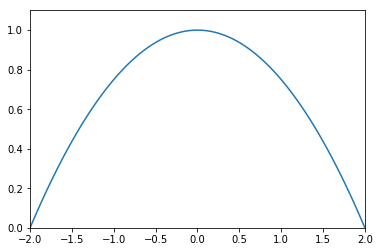

In [6]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(-2, 2, 100)
y = 1-x**2/4
plt.xlim(-2, 2)
plt.ylim(0, 1.1)
plt.plot(x, y)

Consider the following subset of the Iris dataset:

In [ ]:
training_set = [[0, 1], [0.78861006, 0.61489363]]
labels = [0, 1]
test_set = [[-0.549, 0.836], [0.053 , 0.999]]

These examples were cherry-picked because they are relatively straightforward to prepare. In fact, we won't even use them, just some angles: the necessary rotations needed to prepare them. The first element of the training set does not even need that: it is just the $|1\rangle$ state, so we don't specify an angle for it.

In [ ]:
test_angles = [4.30417579487669/2, 3.0357101997648965/2]
training_angle = 1.3245021469658966/4

We create two circuits for the two different test instances. The only difference between the two is the test state preparation part.

In [ ]:
from qiskit.tools.visualization import circuit_drawer
angles = [test_angles[0], training_angle]
state_preparation_0 = prepare_state(q, c, angles)
circuit_0 = interfere_data_and_test_instances(state_preparation_0, q, c, angles)
circuit_drawer(circuit_0)

In [ ]:
angles = [test_angles[1], training_angle]
state_preparation_1 = prepare_state(q, c, angles)
circuit_1 = interfere_data_and_test_instances(state_preparation_1, q, c, angles)
circuit_drawer(circuit_1)

Finally, we post-select on the results where the ancilla was measured in the |0> state.

In [ ]:
def postselect(result_counts):
    total_samples = sum(result_counts.values())

    # define lambda function that retrieves only results where the ancilla is in the |0> state
    post_select = lambda counts: [(state, occurences) for state, occurences in counts.items() if state[-1] == '0']

    # perform the postselection
    postselection = dict(post_select(result_counts))
    postselected_samples = sum(postselection.values())

    print(f'Ancilla post-selection probability was found to be {postselected_samples/total_samples}')

    retrieve_class = lambda binary_class: [occurences for state, occurences in postselection.items() if state[0] == str(binary_class)]

    prob_class0 = sum(retrieve_class(0))/postselected_samples
    prob_class1 = sum(retrieve_class(1))/postselected_samples

    print('Probability for class 0 is', prob_class0)
    print('Probability for class 1 is', prob_class1)

In [ ]:
job = execute(qc0, backend)
result = job.result()
postselect(result.get_counts(qc0))

In [ ]:
job = execute(qc1, backend)
result = job.result()
postselect(result.get_counts(qc1))

# References

[1] M. Schuld, M. Fingerhuth, F. Petruccione. (2017). [Implementing a distance-based classifier with a quantum interference circuit](https://doi.org/10.1209/0295-5075/119/60002). *Europhysics Letters*, 119(6), 60002. 